# **Chapter 14**
## *Outlier Detection Using Unsupervised Machine Learning*, 

This chapter continues from **Chapter 8**, *Outlier Detection Using Statistical Methods*, but focuses on more advanced **unsupervised machine learning** methods. You will use the same datasets from the NAB to allow you to compare statistical and machine learning techniques using the same benchmark data. The techniques cover a variety of machine learning algorithms.


You will be using the same New York taxi dataset to make it easier to compare the results between the different machine learning methods in this chapter and the statistical methods from **Chapter 8**, *Outlier Detection Using Statistical Methods*.  

The recipes that you will encounter in this chapter are as follows:
* Detecting outliers using KNN
* Detecting outliers using LOF
* Detecting outliers using iForest
* Detecting outliers using One-Class Support Vector Machine (OCSVM)
* Detecting outliers using COPOD
* Detecting outliers with PyCaret **see Chapter-14-pycaret** notebook

# -- START: Techical Requirements --

You can install PyOD with either `pip` or `conda`. 

* For a pip install, run the following command:

```
pip install pyod
```


* For a `conda` install, run the following command:

```
conda install -c conda-forge pyod
```

In [1]:
# !pip install pyod
# !conda install -c conda-forge pyod

In [2]:
import matplotlib 
import pandas as pd
import pyod 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.8.3
pandas -> 2.2.1   
statsmodels -> 0.14.1



In [3]:
from pyod import version
version.__version__

'1.1.3'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

### Create DataFrames 

In [6]:
file = Path("../../datasets/Ch14/nyc_taxi.csv")
nyc_taxi_2 = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)
nyc_taxi_2.index.freq = '30T'

In [7]:
print(nyc_taxi_2.shape)

(10320, 1)


In [8]:
nyc_taxi_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


In [9]:
nyc_taxi_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


In [10]:
file = Path("../../datasets/Ch14/nyc_taxi.csv")

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)

In [11]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'top',
                 labels=False,
                 name=None):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX', markersize=9)
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('Number of passengers')
    plt.legend(['nyc taxi','outliers'])
    if name:
        plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch14/images/{name}.png', bbox_inches='tight', dpi=600)
    plt.show()

### Visualize DataFrames

In [12]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [13]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

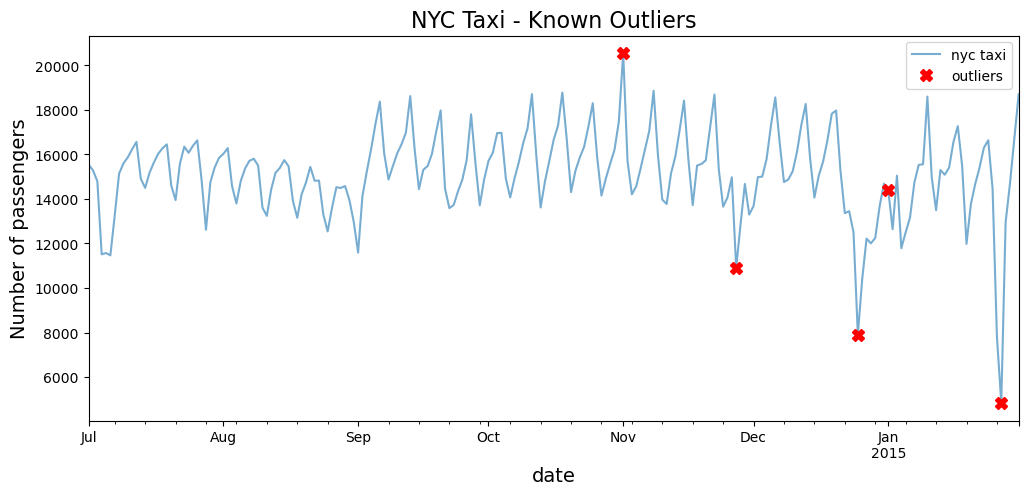

In [14]:
plot_outliers(known_outliers, tx, 'Known Outliers')

# Detecting Outliers using K-Nearest Neighbors

In [15]:
from pyod.models.knn import KNN

In [16]:
# !conda list pyod

In [17]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

In [18]:
knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [19]:
predicted = pd.Series(knn.predict(tx), 
                      index=tx.index)

In [20]:
predicted_conf = pd.Series(knn.predict_confidence(tx), 
                      index=tx.index)

In [21]:
predicted_conf[round(predicted_conf, 4) < 0.99999]

timestamp
2014-11-01    0.624149
2014-11-27    0.304893
2014-12-25    0.624149
2014-12-26    0.452453
2015-01-26    0.624149
2015-01-27    0.984580
dtype: float64

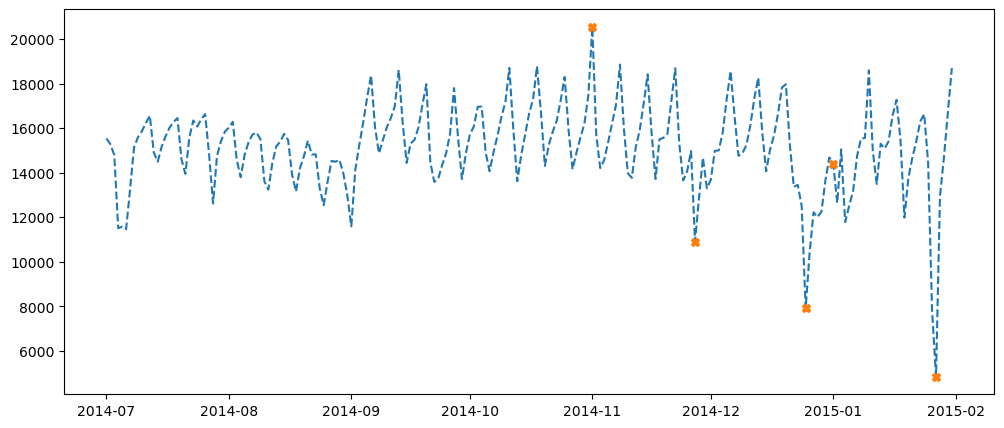

In [22]:
plt.plot(tx, '--')
plt.plot(known_outliers, 'X')

In [23]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [24]:
tx.loc[nyc_dates]

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [25]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


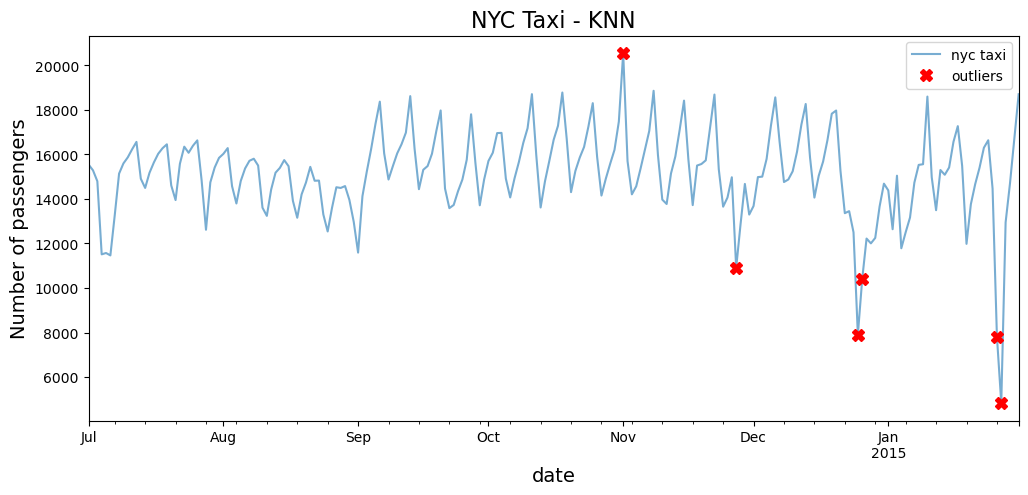

In [26]:
plot_outliers(outliers, tx, 'KNN',  name='fig14.2')

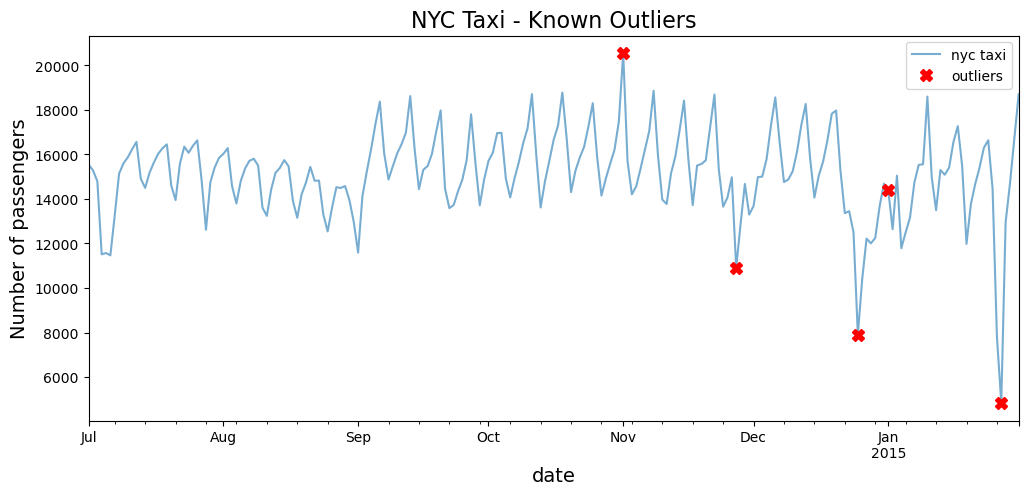

In [27]:
plot_outliers(known_outliers, tx, 'Known Outliers')

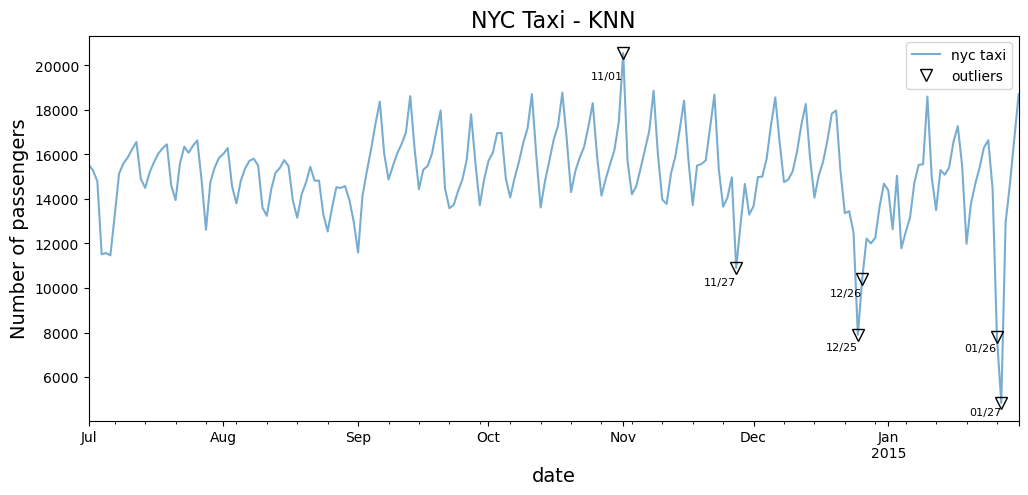

In [28]:
plot_outliers(outliers, 
              tx, 
              'KNN',
              labels=True)

## How it works

In [29]:
knn_scores = knn.decision_scores_
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000
2014-09-27,225.604167


In [30]:
n = int(len(tx)*0.03)
knn_scores_df.nlargest(n, 'score')

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000


In [31]:
knn_scores_df.min()

score    11.745833
dtype: float64

In [32]:
knn_scores_df.max()

score    4862.058333
dtype: float64

In [33]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

50.77533664068037

In [34]:
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
knn_proba_df.nlargest(n, 'Proba_Anomaly')

,Proba_Normal,Proba_Anomaly
timestamp,,
2015-01-27,27.337,72.663
2015-01-26,64.256,35.744
2014-12-25,64.599,35.401
2014-11-01,70.682,29.318
2014-12-26,84.341,15.659
2014-11-27,90.548,9.452


In [35]:
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
knn_proba_df.nlargest(n, 'Proba_Anomaly')

,Proba_Normal,Proba_Anomaly
timestamp,,
2015-01-27,0.000,100.000
2015-01-26,0.012,99.988
2014-12-25,0.014,99.986
2014-11-01,0.189,99.811
2014-12-26,12.225,87.775
2014-11-27,40.330,59.670


In [36]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')
# load the model
knn = load('knn_outliers.joblib')

In [37]:
knn

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

## There is more

In [38]:
from pyod.utils.utility import standardizer
scaled = standardizer(tx)
predicted = pd.Series(knn.fit_predict(scaled), 
                      index=tx.index)
outliers_scaled = predicted[predicted == 1]
outliers_scaled = tx.loc[outliers.index] 
outliers_scaled

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


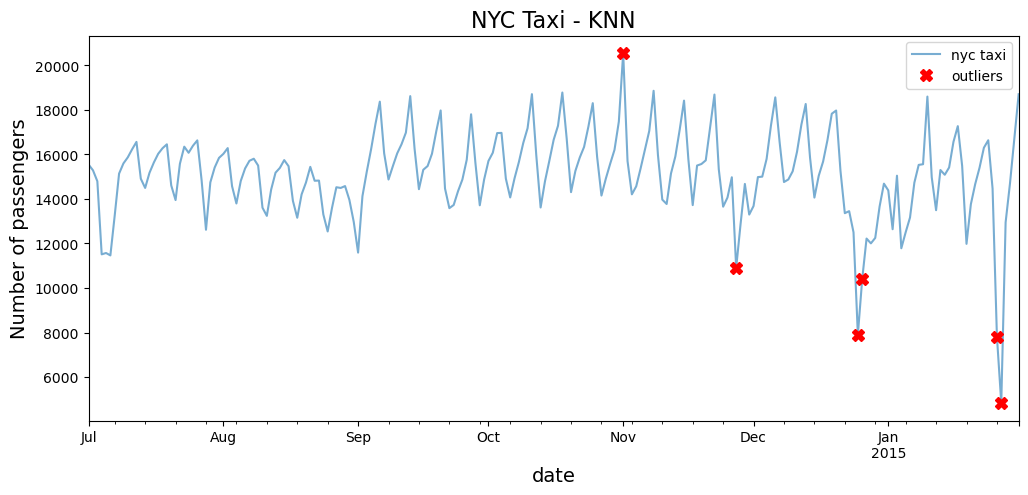

In [39]:
plot_outliers(outliers, tx, 'KNN')

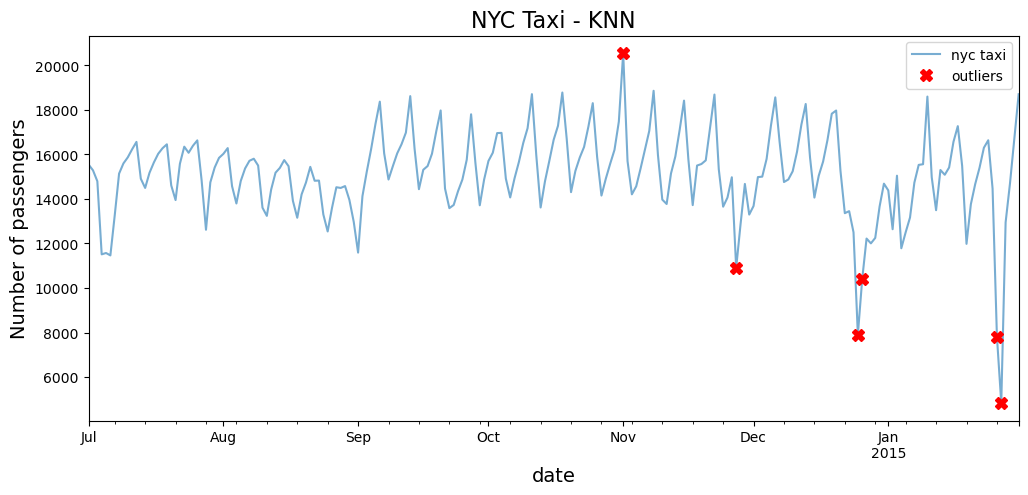

In [40]:
plot_outliers(outliers_scaled, tx, 'KNN')

In [41]:
def knn_anomaly(df, method='mean', contamination=0.05, k=5):
    knn = KNN(contamination=contamination,
              method=method,
              n_neighbors=5)
    knn.fit(df)
    
    decision_score = pd.DataFrame(knn.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, knn.threshold_

In [42]:
for method in ['mean', 'median', 'largest']:
    o, t = knn_anomaly(tx, method=method)
    print(f'Method= {method}, Threshold= {t}')
    print(o)


Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

# Detecting Outliers Using Local Outlier Factor LOF

In [43]:
from pyod.models.lof import LOF

In [44]:
lof = LOF(contamination=0.03, n_neighbors=5)

In [45]:
lof.fit(tx)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [46]:
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)

In [47]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [48]:
tx.loc[nyc_dates]

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [49]:
tx.shape

(215, 1)

In [50]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-10-31,17473.354167
2014-11-01,20553.500000
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [51]:
lof.threshold_

1.7717390813973128

In [52]:
lof_scores = lof.decision_scores_
lof_scores_df = (pd.DataFrame(lof_scores, 
             index=tx.index, 
             columns=['score']))
lof_scores_df[lof_scores_df['score'] >= lof.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571
2015-01-12,1.796124


In [53]:
n = int(len(tx)*0.03)
lof_scores_df.nlargest(n, 'score')

,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571


In [54]:
lof_proba = lof.predict_proba(tx, method='linear')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
lof_proba_df[:n].sort_index()

,Proba_Normal,Proba_Anomaly
timestamp,,
2014-10-31,92.361,7.639
2014-11-01,22.033,77.967
2014-12-25,89.121,10.879
2014-12-26,91.625,8.375
2015-01-26,88.972,11.028
2015-01-27,83.610,16.390


In [55]:
lof_proba = lof.predict_proba(tx, method='unify')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
lof_proba_df[:n].sort_index()

,Proba_Normal,Proba_Anomaly
timestamp,,
2014-10-31,47.955,52.045
2014-11-01,0.000,100.000
2014-12-25,25.309,74.691
2014-12-26,42.020,57.980
2015-01-26,24.484,75.516
2015-01-27,5.954,94.046


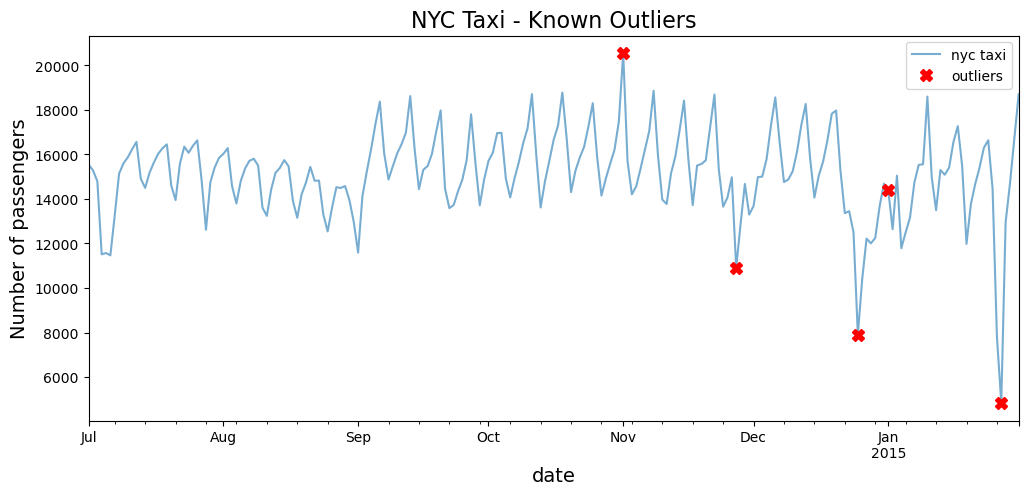

In [56]:
plot_outliers(known_outliers, tx, 'Known Outliers')

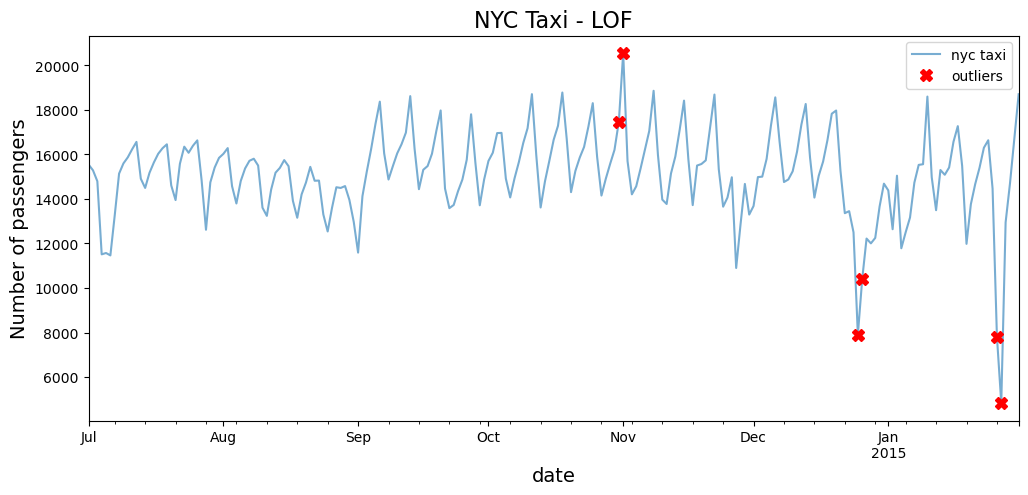

In [57]:
plot_outliers(outliers, tx, 'LOF', name='fig14.4')

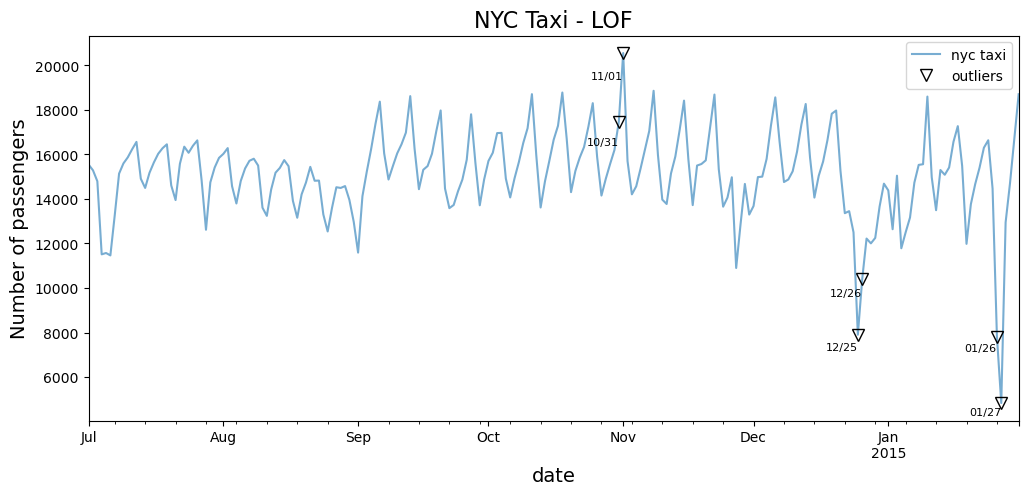

In [58]:
plot_outliers(outliers, tx, 'LOF', labels=True)

## There is more

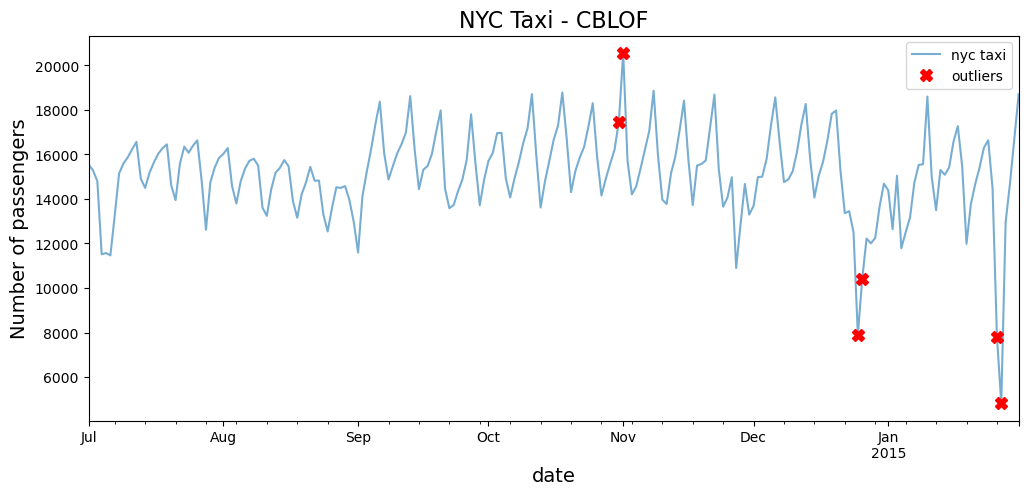

In [59]:
from pyod.models.cblof import CBLOF
cblof = CBLOF(n_clusters=4, contamination=0.03)
cblof.fit(tx)
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
plot_outliers(outliers, tx, 'CBLOF', name='fig14.5')

# Detecting Outliers using Isolation Forests

In [60]:
from pyod.models.iforest import IForest

In [61]:
iforest = IForest(contamination=0.03,
                 n_estimators=100)
iforest.fit(tx)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [62]:
predicted = pd.Series(iforest.predict(tx), 
                      index=tx.index)

In [63]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [64]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


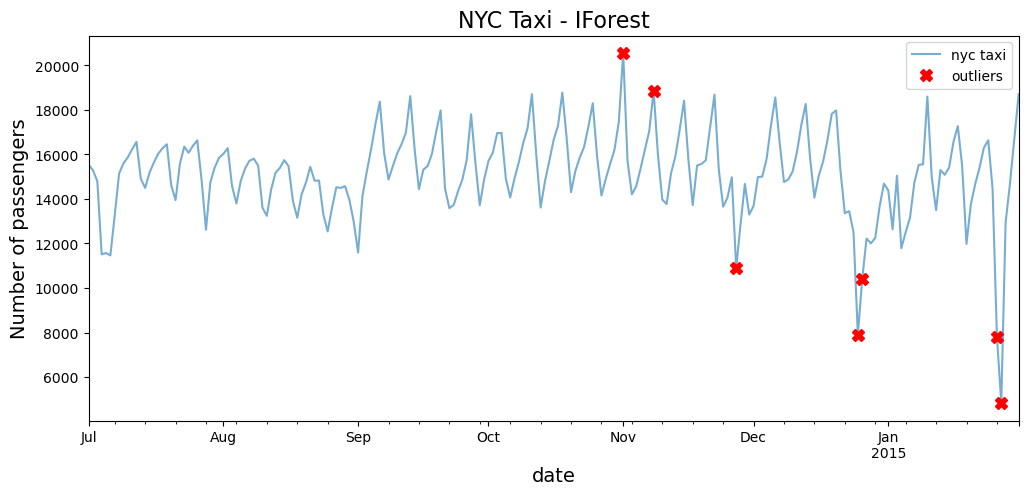

In [65]:
plot_outliers(outliers, tx, 'IForest', name='fig14.6')

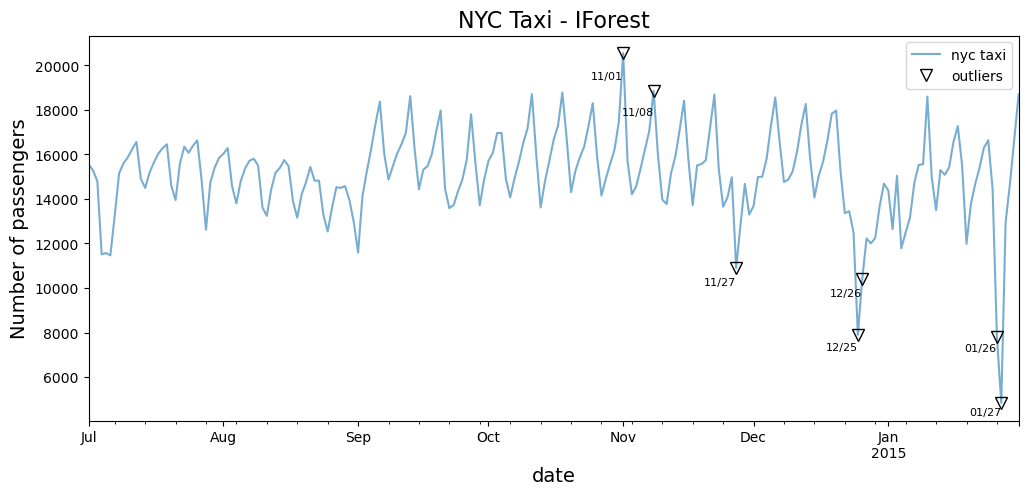

In [66]:
plot_outliers(outliers, 
              tx, 
              'IForest',
              labels=True)

In [67]:
iforest.threshold_

-5.863365348801608e-16

In [68]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [69]:
iforest_scores = iforest.decision_scores_
iforest_scores_df = (pd.DataFrame(iforest_scores, 
             index=tx.index, 
             columns=['score']))
iforest_scores_df[iforest_scores_df['score'] >= iforest.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2015-01-27,0.224864
2014-11-01,0.190415
2015-01-26,0.113921
2014-12-25,0.109359
2014-12-26,0.069040
2014-11-27,0.031292
2014-11-08,0.016716


## There is more

In [70]:
import sklearn
sklearn.__version__

'1.4.1.post1'

In [71]:
from sklearn.ensemble import IsolationForest

In [72]:
sk_iforest = IsolationForest(contamination=0.03)
sk_prediction = pd.Series(sk_iforest.fit_predict(tx), 
                      index=tx.index)
sk_outliers = sk_prediction[sk_prediction == -1]
sk_outliers = tx.loc[sk_outliers.index] 
sk_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


# Detecing Outliers using Copula-Based Outlier Detection (COPOD)

In [73]:
from pyod.models.copod import COPOD

In [74]:
copod = COPOD(contamination=0.03)
copod.fit(tx)

COPOD(contamination=0.03, n_jobs=1)

In [75]:
predicted = pd.Series(copod.predict(tx), 
                      index=tx.index)

In [76]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [77]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-04,11511.770833
2014-07-06,11464.270833
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [78]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


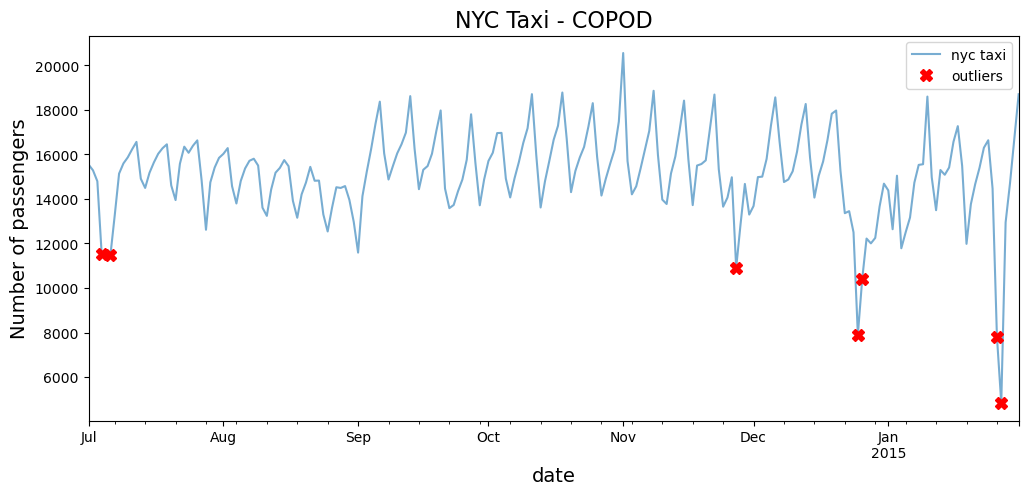

In [79]:
plot_outliers(outliers, tx, 'COPOD', name='fig14.10')

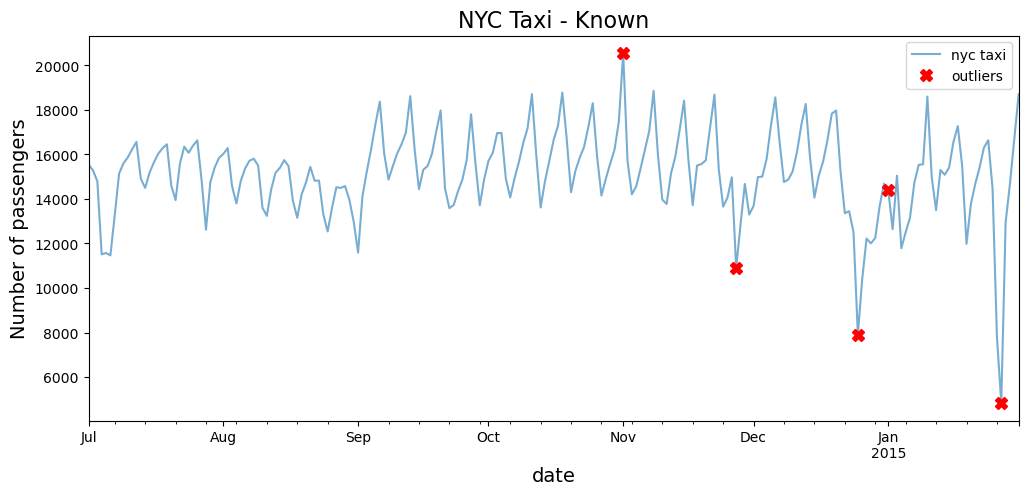

In [80]:
plot_outliers(known_outliers, tx, 'Known')

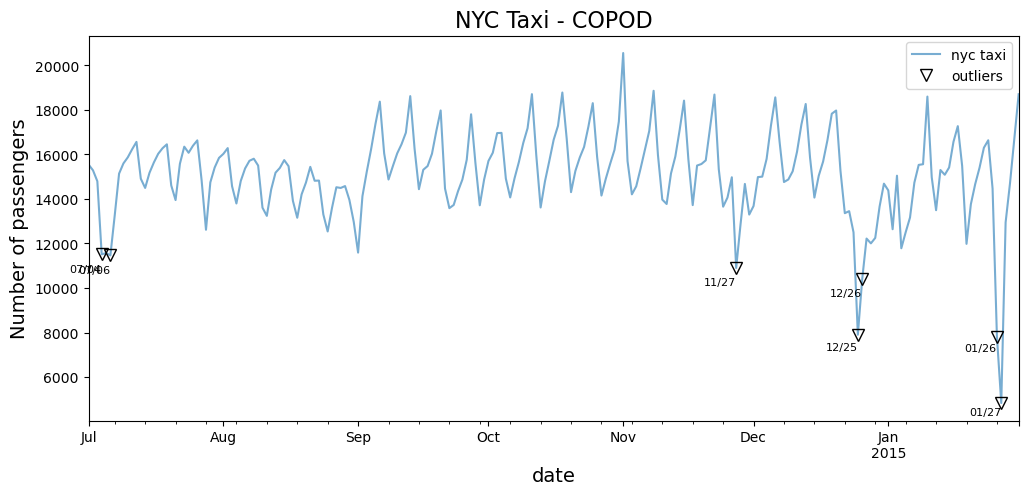

In [81]:
plot_outliers(outliers, 
              tx, 
              'COPOD',
              labels=True)

## There is more

In [82]:
from pyod.models.mad import MAD

In [83]:
mad = MAD(threshold=3)

In [84]:
predicted = pd.Series(mad.fit_predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 

In [85]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


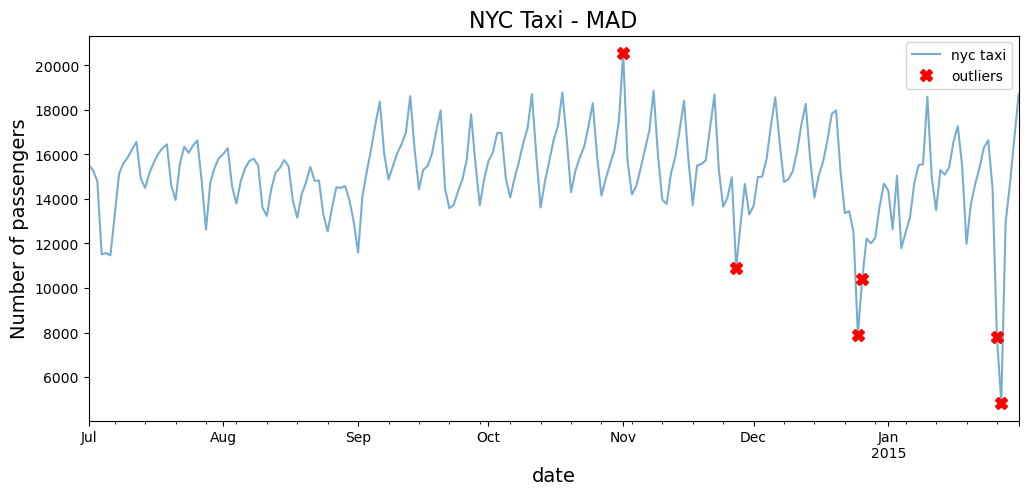

In [86]:
plot_outliers(outliers, tx, 'MAD')

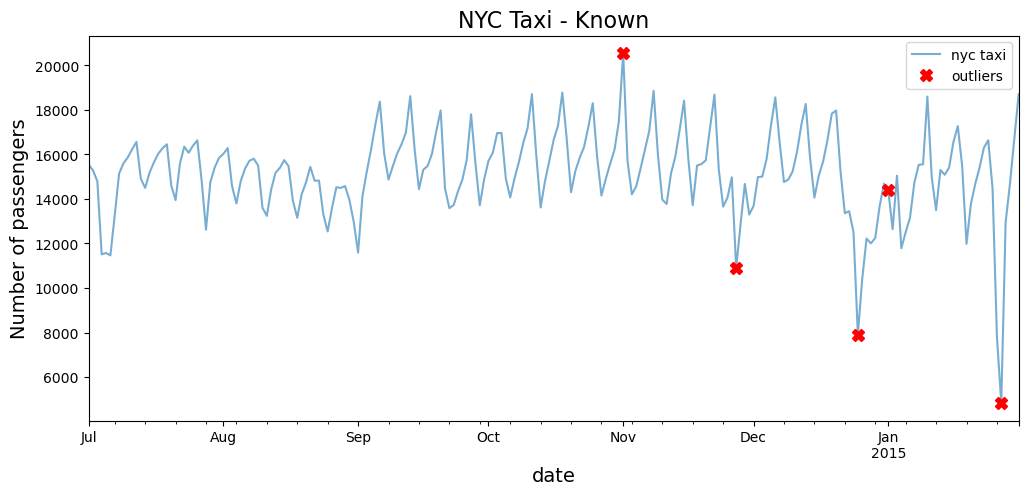

In [87]:
plot_outliers(known_outliers, tx, 'Known')

In [88]:
from pyod.models.loda import LODA

In [89]:
loda = LODA(contamination=0.03)
loda.fit(tx)

LODA(contamination=0.03, n_bins=10, n_random_cuts=100)

In [90]:
predicted = pd.Series(loda.predict(tx), 
                      index=tx.index)

In [91]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [92]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


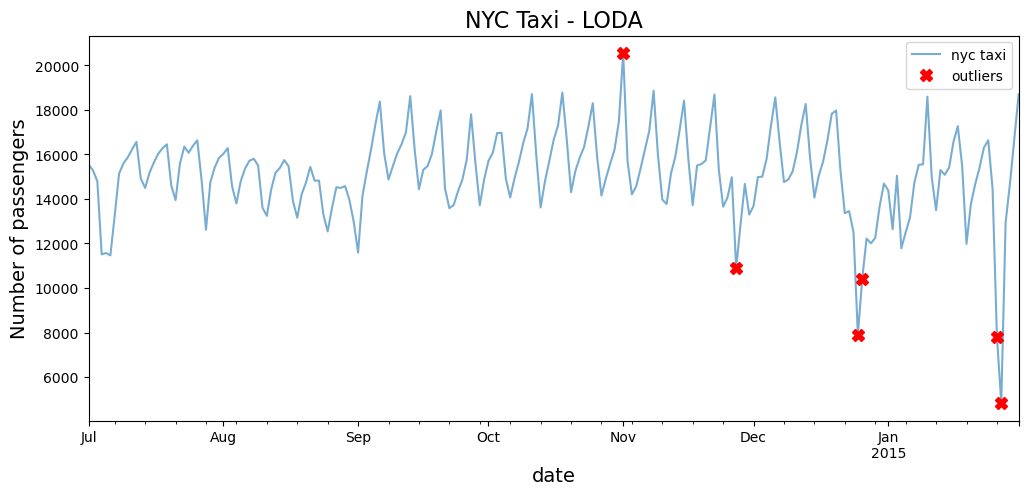

In [93]:
plot_outliers(outliers, tx, 'LODA')

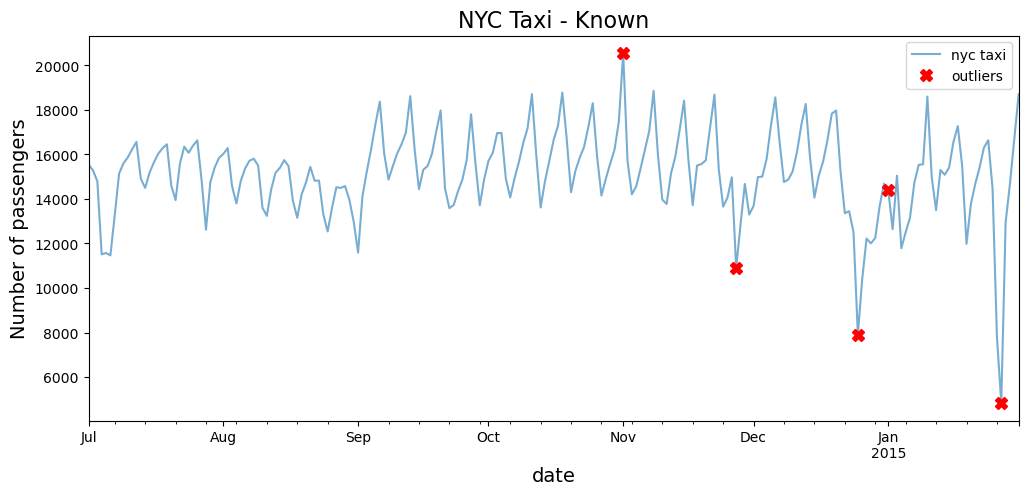

In [94]:
plot_outliers(known_outliers, tx, 'Known')

# Detecting Outliers using One Class SVM

In [95]:
from pyod.models.ocsvm import OCSVM

In [96]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf')
ocsvm.fit(tx)

OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [97]:
predicted = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

In [98]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  5


In [99]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-08-09,15499.708333
2014-11-18,15499.437500
2014-11-27,10899.666667
2014-12-24,12502.000000
2015-01-05,12502.750000


In [100]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


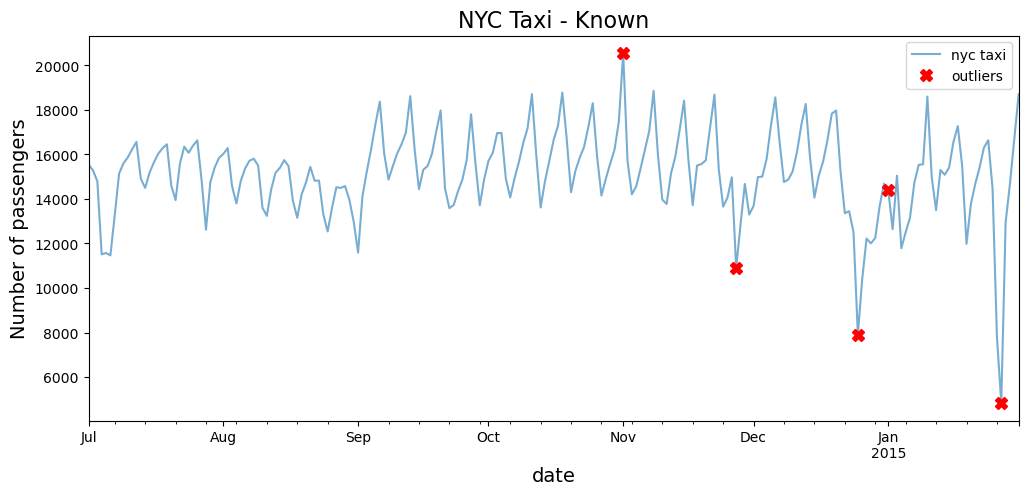

In [101]:
plot_outliers(known_outliers, tx, 'Known')

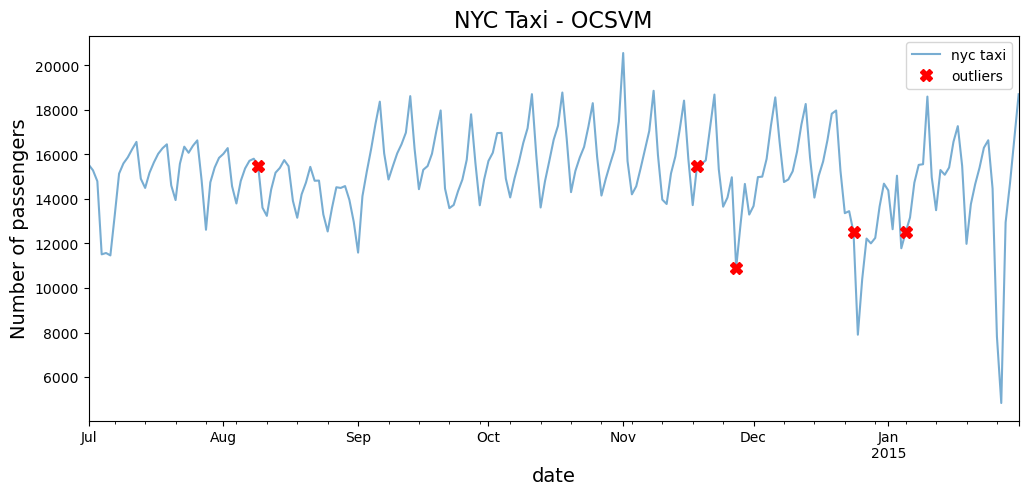

In [102]:
plot_outliers(outliers, tx, 'OCSVM', name='fig14.7')

In [103]:
from pyod.utils.utility import standardizer
scaled = standardizer(tx)
predicted = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-06,11464.270833
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


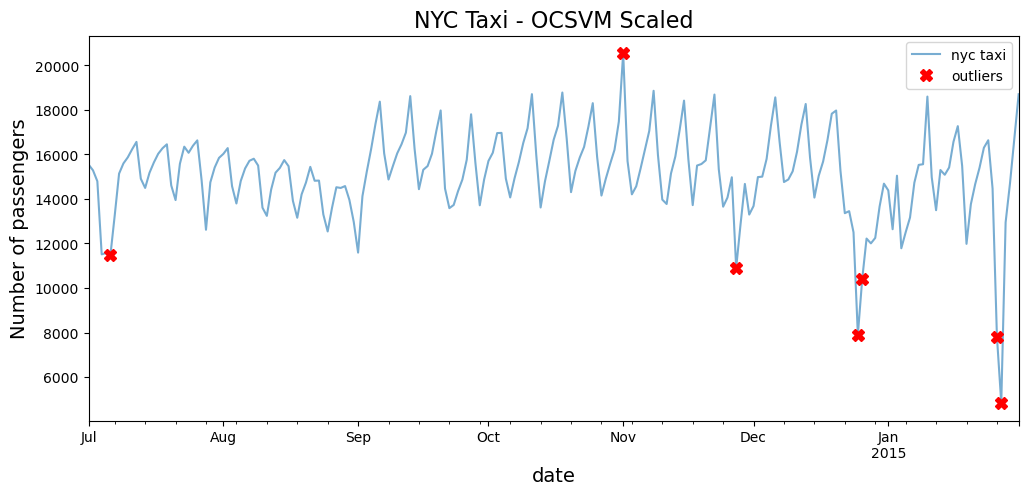

In [104]:
plot_outliers(outliers, tx, 'OCSVM Scaled', name='fig14.8')

## There is more

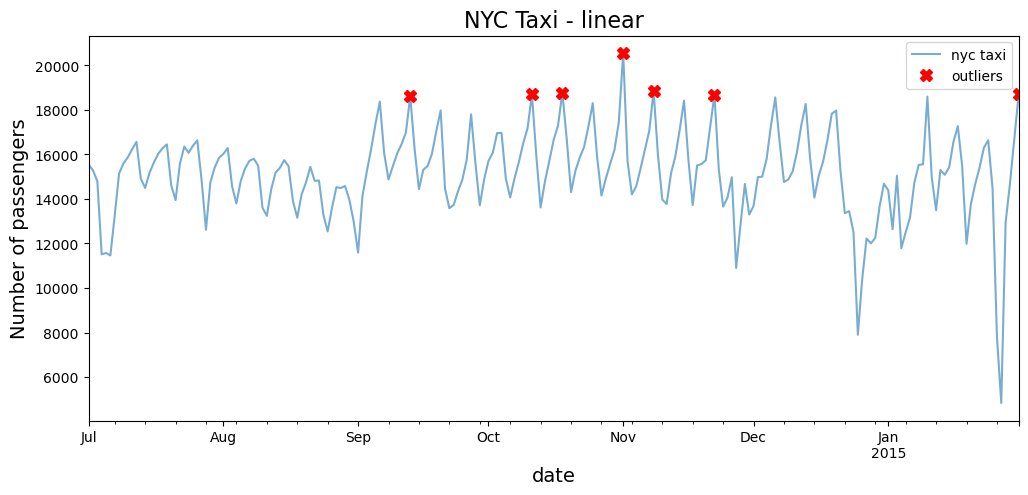

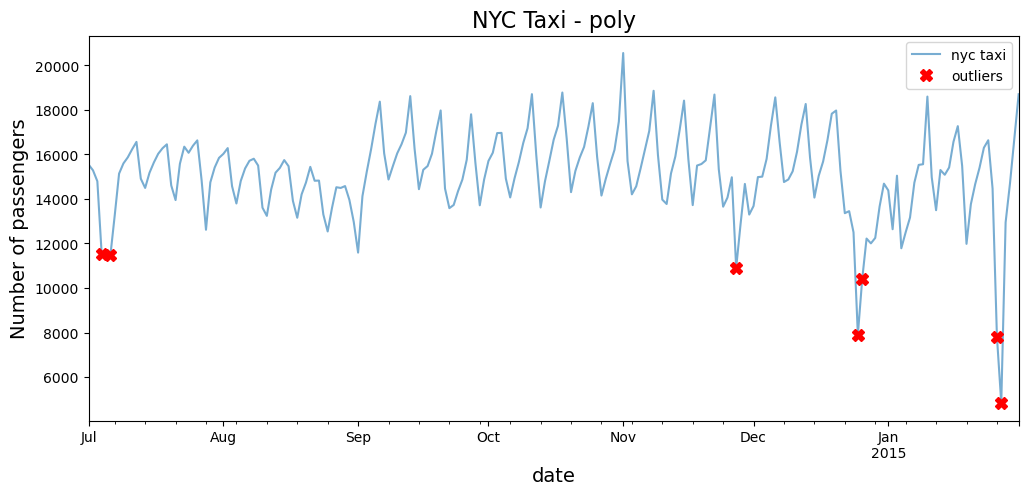

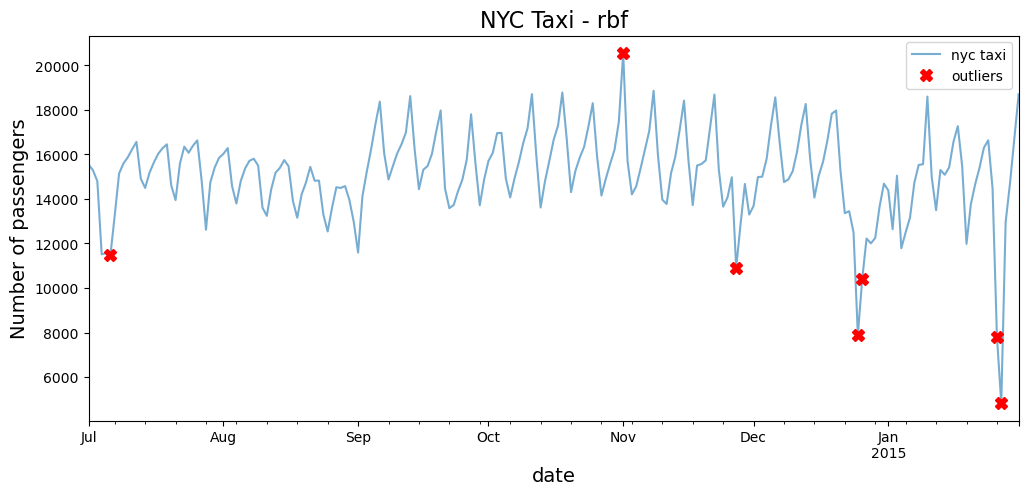

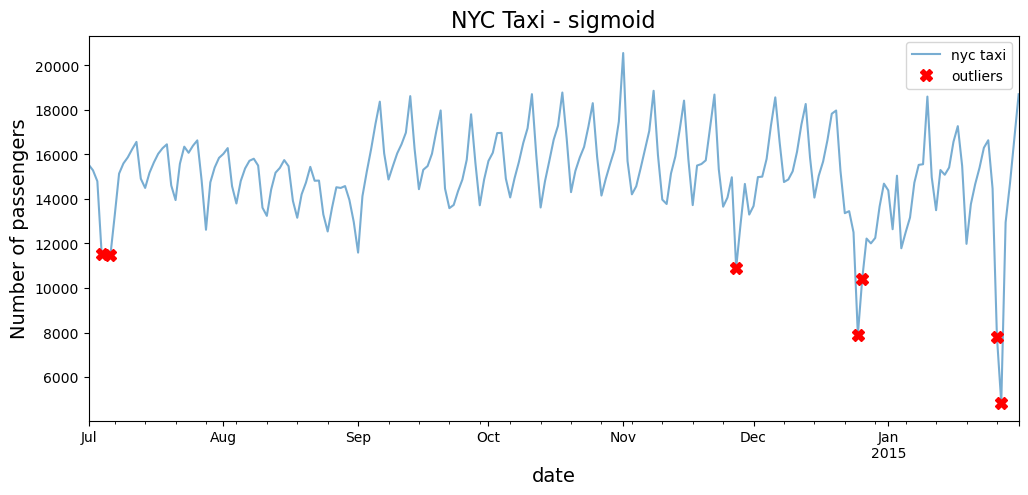

In [105]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, kernel=kernel)
    predict = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index, name=kernel)
    outliers = predict[predict == 1]
    outliers = tx.loc[outliers.index]
    plot_outliers(outliers, tx, kernel)
    